# Homework 4 Assignment 1

### Chris Prince (cmp670)

>Test if the distribution of ages is the same for 
>    
>1. male and female riders
>    
>2. day and night riders
>    
>Use 3 tests: KS, Pearson's, Spearman's

Imports and setting a random seed:

In [1]:
import pylab as pl
import pandas as pd
import numpy as np
import zipfile as zf
%pylab inline

import os

#Feel free to uncomment to load your plot style settings (I still need to make my own)
#import json
#s = json.load( open(os.getenv ('PUI2015')+"/fbb_matplotlibrc.json") )
#pl.rcParams.update(s)

np.random.seed(11001001)

Populating the interactive namespace from numpy and matplotlib


I am reading in data from January 2015. Later we will look at a larger set of months.

In [2]:
cbcols = ['birth year', 'gender', 'usertype', 'starttime']
with zf.ZipFile(os.getenv('PUI2015') + '/citibikes/data/201501-citibike-tripdata.zip', 'r') as z:    
    df = pd.read_csv(z.open('201501-citibike-tripdata.csv'), usecols = cbcols)
#df=pd.read_csv(os.getenv ('PUI2015')+'/notebooks/data/201501-citibike-tripdata.csv')
print df.columns

Index([u'starttime', u'usertype', u'birth year', u'gender'], dtype='object')


#BY GENDER
splitting data by gender and extracting the age happens in the cell below

In [3]:
#df is the dataframe where the content of the csv file is stored
df['ageM'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['gender'] == 1)]
df['ageF'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['gender'] == 2)]

Plot age in 5 year bins. 

the next several steps are needed if you want to code up the KS test from scratch. that is for extra credit, so if you do not want to do it you may not need to plot split the distribution in bins and create the cumulative HOWEVER it is a great idea to do it anyways to explore your data viaually! remember Ascombe's quartet!!

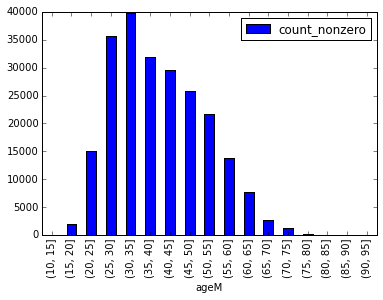

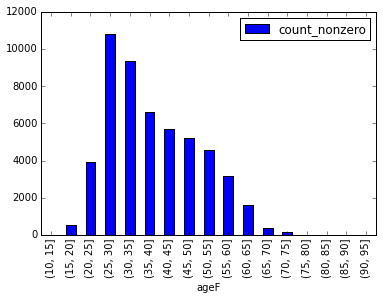

In [4]:
bins = np.arange(10, 99, 5)
df.ageM.groupby(pd.cut(df.ageM, bins)).agg([count_nonzero]).plot(kind='bar')
df.ageF.groupby(pd.cut(df.ageF, bins)).agg([count_nonzero]).plot(kind='bar')

this is how the cumulative distributions look like.  Notice that i am normalizing them! if i want to treat an observed distribution like a probablility distribution i have to normalize it

          count_nonzero
ageM                   
(10, 15]            NaN
(15, 20]       0.001657
(20, 25]       0.010955
(25, 30]       0.060955
(30, 35]       0.065548
(35, 40]       0.052146
(40, 45]       0.031750
(45, 50]       0.018657
(50, 55]       0.011015
(55, 60]       0.010957
(60, 65]       0.008149
(65, 70]       0.003203
(70, 75]       0.000663
(75, 80]       0.000188
(80, 85]       0.000002
(85, 90]            NaN
(90, 95]            NaN


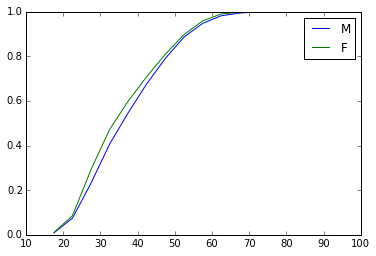

In [5]:
#print df.ageS, df.ageS.cumsum()

csM=df.ageM.groupby(pd.cut(df.ageM, bins)).agg([count_nonzero]).cumsum()

csF=df.ageF.groupby(pd.cut(df.ageF, bins)).agg([count_nonzero]).cumsum()

print np.abs(csM / csM.max()-csF / csF.max())

pl.plot(bins[:-1] + 2.5, csM / csM.max(), label = "M")
pl.plot(bins[:-1] + 2.5, csF / csF.max(), label = "F")
pl.legend()

Cumulative age distribution for men and women; age on the x-axis.

they look pretty darn similar! that sets my expectation for the tests to come. if i wanted to code the KS test by hand i woud have everything i need: the normalized cumulative distributions can be subtracted from each other and the max distance can be seeked. 

Notice that there amay be Nan values you are gonna have to deal with! you can do that for example with a Boolean statementsuch as  df.ageF[~np.isnan(df.ageF)] or you can use numpy functions that deal with Nan values: nansum, nanmean, nanstd...

lets run the scipy KS test

In [6]:
import scipy.stats

#KS tests to compare 2 samples

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html


In [7]:
ks=scipy.stats.ks_2samp(df.ageM, df.ageF)
print 'KS = %s, p-value = %s'%(ks)

KS = 0.615197932426, p-value = 0.0


In [8]:
ks=scipy.stats.ks_2samp(df.ageM[~np.isnan(df.ageM)], df.ageF[~np.isnan(df.ageF)])
print 'KS = %s, p-value = %s'%(ks)

KS = 0.0674425578022, p-value = 4.04086119991e-168


The p-value is zero, so the null hypothesis (that the samples are drawn from the same distribution) is rejected. Additionally:

>The Null hypothesis is rejected if 
>
>$D_KS(n1,n2) > c(\alpha) \sqrt{\frac{(n1+n2)}{n1n2}}$
>
>where $c(\alpha$) is the inverse of the KS distribution, and you do not have to know how to get that cause there are >tables that list critical values!! 


Here is the critical values table.
Let's set $\alpha=0.01$.

| 
|-
| $\alpha$ | 0.10 | 0.05 | 0.025 | 0.01 | 0.005 | 0.001
| $c(\alpha)$ | 1.22 | 1.36 | 1.48 | 1.63 | 1.73 | 1.95

Create no-nan arrays for men and women, and calculate the critical value for the KS statistic at our $\alpha$

In [9]:
Mnonan = df.ageM[~np.isnan(df.ageM)]
Fnonan = df.ageF[~np.isnan(df.ageF)]

In [10]:
c = {0.10: 1.22, 0.05: 1.36, 0.025: 1.48, 0.01: 1.63, 0.005: 1.73, 0.001: 1.95}
n1 = Mnonan.count()
n2 = Fnonan.count()
KS_crit_val = lambda alpha, N1, N2: c[alpha] * np.sqrt((N1+N2)/(N1*N2*1.))
KS_crit_val(0.01, n1, n2)

0.0079163222814646241

Since the statistic is greater than this critical value, we reject the null hypothesis (as above).

### Pearson's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr



Because the pearson and spearman tests require that the sample sets be of equal size, we need to create a routine to create a subsample for the larger of the two. Because this is a random process, we have set a seed at the top of this notebook, and we run multiple iterations and average the values over them.

In [11]:
def pearsonr_arblen(l1, l2, numiter = 10, debug = False):
    intermed = np.zeros((numiter, 2))
    for i in range(numiter):
        if len(l1) < len(l2):
            l2_resize = np.random.choice(l2, len(l1), replace = False)
            l1_resize = l1
        elif len(l1) > len(l2):
            l1_resize = np.random.choice(l1, len(l2), replace = False)
            l2_resize = l2
        else:
            l1_resize = l1
            l2_resize = l2
            #The samples are equal and we don't need to do anything to them  
        intermed[i,:] = scipy.stats.pearsonr(l1_resize, l2_resize)
        
    if debug: print intermed
    return [intermed[:,0].mean(), intermed[:,1].mean()]

In [12]:
pearsonr_arblen(Mnonan, Fnonan, numiter=25, debug = True)

[[ -1.43840638e-03   7.42690442e-01]
 [ -8.81565846e-03   4.42128654e-02]
 [  1.02421229e-04   9.81350390e-01]
 [  1.04139850e-03   8.12127731e-01]
 [  5.31954846e-04   9.03366384e-01]
 [  5.17704390e-03   2.37371433e-01]
 [  4.21269835e-03   3.36309433e-01]
 [  3.56408587e-03   4.15962316e-01]
 [  4.02224770e-03   3.58610953e-01]
 [ -5.60800335e-03   2.00564860e-01]
 [  3.54192507e-03   4.18867111e-01]
 [ -4.46493806e-03   3.08177700e-01]
 [ -1.15642548e-03   7.91829971e-01]
 [  3.44822743e-03   4.31280038e-01]
 [ -3.65247262e-03   4.04495633e-01]
 [ -1.88594106e-03   6.66879105e-01]
 [  1.70248672e-03   6.97598206e-01]
 [ -3.41631757e-04   9.37850492e-01]
 [ -1.11212537e-04   9.79749934e-01]
 [ -5.07645812e-03   2.46609102e-01]
 [  3.23893785e-03   4.59763799e-01]
 [  4.27404220e-03   3.29320344e-01]
 [ -9.78517146e-04   8.23278384e-01]
 [  1.09999205e-03   8.01771557e-01]
 [ -1.43001380e-03   7.44139041e-01]]


[3.9911317234096859e-05, 0.56296708897840142]

The coefficient and very small (nearly zero) so there is almost no correlation.

#Spearman's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr

In [13]:
def spearmanr_arblen(l1, l2, numiter = 10, debug = False):
    intermed = np.zeros((numiter, 2))
    for i in range(numiter):
        if len(l1) < len(l2):
            l2_resize = np.random.choice(l2, len(l1), replace = False)
            l1_resize = l1
        elif len(l1) > len(l2):
            l1_resize = np.random.choice(l1, len(l2), replace = False)
            l2_resize = l2
        else:
            l1_resize = l1
            l2_resize = l2
            #The samples are equal and we don't need to do anything to them  
        intermed[i,:] = scipy.stats.spearmanr(l1_resize, l2_resize)
        
    if debug: print intermed
    return [intermed[:,0].mean(), intermed[:,1].mean()]

In [14]:
spearmanr_arblen(Mnonan, Fnonan, numiter=25, debug = True)

[[ -1.02198480e-02   1.96706254e-02]
 [ -4.35702424e-03   3.20016819e-01]
 [ -9.43556142e-03   3.12748109e-02]
 [ -8.06696583e-03   6.55950004e-02]
 [  8.08454872e-03   6.50092561e-02]
 [  8.37822808e-03   5.58473004e-02]
 [  3.40590426e-03   4.36956150e-01]
 [ -1.58077815e-03   7.18258943e-01]
 [ -4.98148506e-04   9.09480249e-01]
 [  3.98700072e-03   3.62838079e-01]
 [ -3.81813775e-03   3.83519486e-01]
 [  4.00353933e-03   3.60850754e-01]
 [  2.93944217e-03   5.02296707e-01]
 [ -5.34559138e-03   2.22445395e-01]
 [  7.99649574e-04   8.55185021e-01]
 [  5.89471153e-03   1.78501925e-01]
 [ -7.55583943e-05   9.86241201e-01]
 [  4.55311403e-03   2.98721852e-01]
 [ -4.21090968e-04   9.23435559e-01]
 [  2.81223464e-03   5.20972377e-01]
 [  7.95681298e-04   8.55895783e-01]
 [  3.72785368e-04   9.32196131e-01]
 [  2.04180667e-03   6.41209035e-01]
 [ -3.18930405e-03   4.66670112e-01]
 [ -3.34467694e-03   4.45243222e-01]]


[-9.1361568686704507e-05, 0.46233327185354223]

Again the coefficient is nearly zero, so there is no correlation.

## DO THE SAME FOR THE DISTRIBUTION OF RIDERS DURING THE DAY VS DURING THE NIGHT!

hint: remember how I converted the starttime last time in my own citibikes notebook into units that are easy to read. 
df['mystarttime'] = ...
then you can use something like
df['mystarttime'].dt.hour

In [15]:
df['starthour'] = pd.to_datetime(df['starttime']).dt.hour

In [16]:
#df is the dataframe where the content of the csv file is stored; day time is 6am to 8pm; night is outside that.
df['ageDay'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (abs(df['starthour'] - 12.5) < 7)]
df['ageNight'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (abs(df['starthour'] - 12.5) > 7)]

In [17]:
print len(df['ageDay'][~np.isnan(df['ageDay'])]), len(df['ageNight'][~np.isnan(df['ageNight'])])

243146 36778


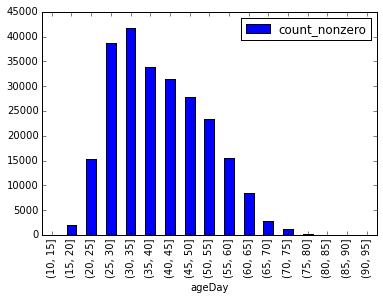

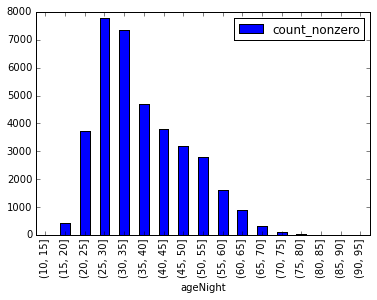

In [18]:
bins = np.arange(10, 99, 5)
df.ageDay.groupby(pd.cut(df.ageDay, bins)).agg([count_nonzero]).plot(kind='bar')
df.ageNight.groupby(pd.cut(df.ageNight, bins)).agg([count_nonzero]).plot(kind='bar')

          count_nonzero
ageDay                 
(10, 15]            NaN
(15, 20]       0.003660
(20, 25]       0.041456
(25, 30]       0.093813
(30, 35]       0.121302
(35, 40]       0.109098
(40, 45]       0.083141
(45, 50]       0.055513
(50, 55]       0.035244
(55, 60]       0.015175
(60, 65]       0.004727
(65, 70]       0.001649
(70, 75]       0.000066
(75, 80]       0.000161
(80, 85]       0.000070
(85, 90]            NaN
(90, 95]       0.000000


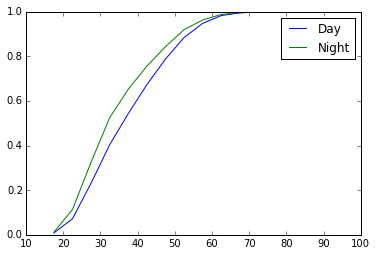

In [19]:
#print df.ageS, df.ageS.cumsum()

csDay=df.ageDay.groupby(pd.cut(df.ageDay, bins)).agg([count_nonzero]).cumsum()

csNight=df.ageNight.groupby(pd.cut(df.ageNight, bins)).agg([count_nonzero]).cumsum()

print np.abs(csDay / csDay.max()-csNight / csNight.max())

pl.plot(bins[:-1] + 2.5, csDay / csDay.max(), label = "Day")
pl.plot(bins[:-1] + 2.5, csNight / csNight.max(), label = "Night")
pl.legend()

Cumulative age distribution for day and night riders; age along x-axis. 

In [20]:
Daynonan = df.ageDay[~np.isnan(df.ageDay)]
Nightnonan = df.ageNight[~np.isnan(df.ageNight)]

In [21]:
ks=scipy.stats.ks_2samp(Daynonan, Nightnonan)
print 'KS = %s, p-value = %s'%(ks)

KS = 0.12505175929, p-value = 0.0


The KS statistic has a p-value of 0, so we again reject the null hypothesis that the samples come from the same distribution.

In [22]:
pearsonr_arblen(Daynonan, Nightnonan)

[-0.00046276844598724649, 0.56776912993449202]

The coefficient is nearly zero, so there is no correlation.

In [23]:
spearmanr_arblen(Daynonan, Nightnonan)

[-0.00090243605728520366, 0.5382055496429613]

Again, no correlation.

## Repeat all of this for every data set in 2015
As can be seen below, the KS test rejects the null hypothesis for every month, and the correlation coefficients are essentially zero for every month.

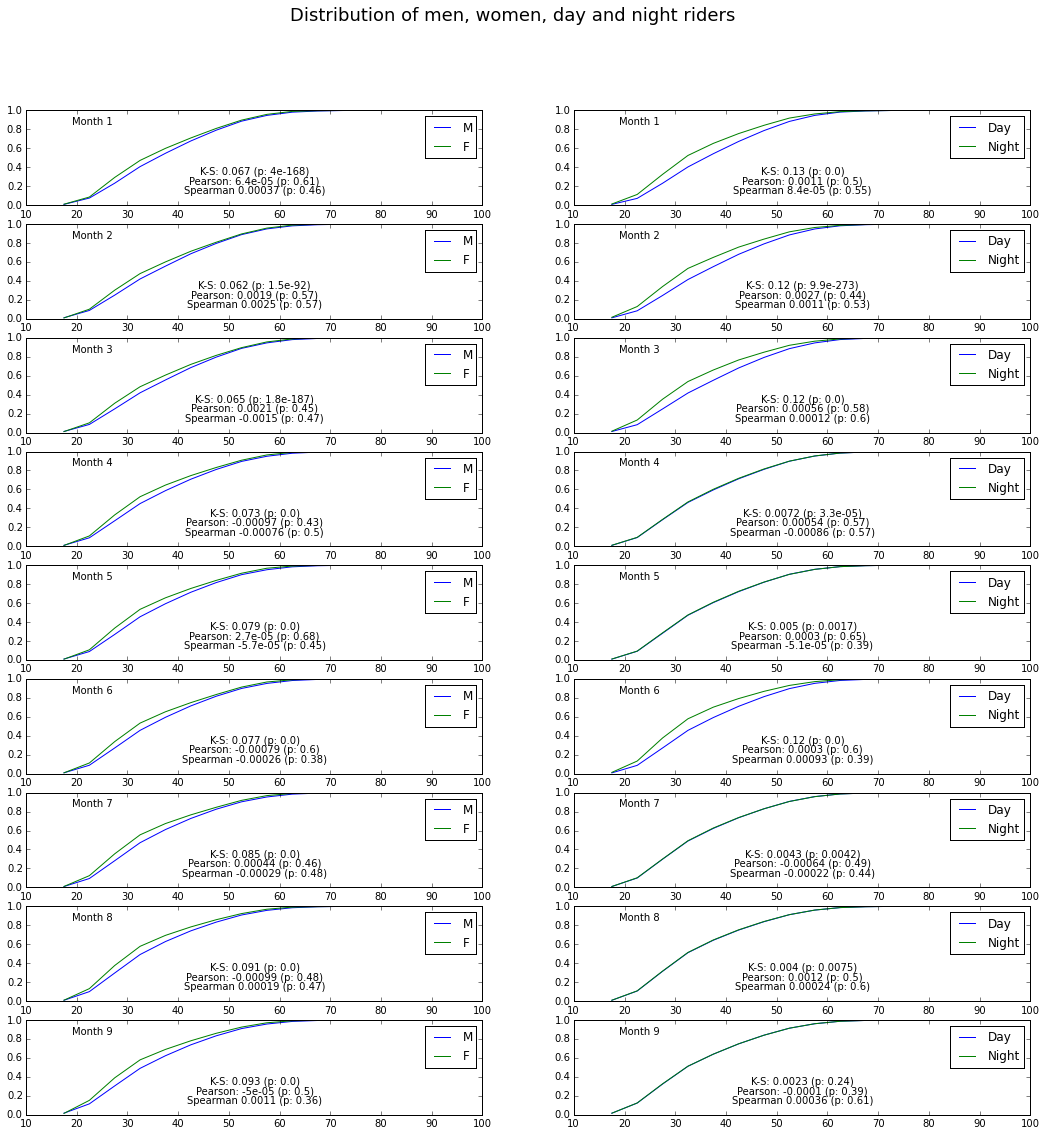

In [25]:
figMFDN = pl.figure(figsize=(18,18))
figMFDN.suptitle('Distribution of men, women, day and night riders',size=18)

for i in range(1,10):
    with zf.ZipFile(os.getenv('PUI2015') + '/citibikes/data/20150%i-citibike-tripdata.zip'%(i), 'r') as z:    
        df = pd.read_csv(z.open('20150%i-citibike-tripdata.csv'%(i)), usecols = cbcols)
    
    ax_MF = figMFDN.add_subplot(9,2,(2*i)-1)
    ax_DN = figMFDN.add_subplot(9,2,(2*i))
    
    #pd.to_datetime is WAAAAAY too slow
    df['starthour'] = df['starttime'].apply(lambda v: int(v[-5:-3]))  #pd.to_datetime(df['starttime']).dt.hour
    df['ageM'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['gender'] == 1)]
    df['ageF'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['gender'] == 2)]
    df['ageDay'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (abs(df['starthour'] - 12.5) < 7)]
    df['ageNight'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (abs(df['starthour'] - 12.5) > 7)]
    
    csM=df.ageM.groupby(pd.cut(df.ageM, bins)).agg([count_nonzero]).cumsum()
    csF=df.ageF.groupby(pd.cut(df.ageF, bins)).agg([count_nonzero]).cumsum()
    csDay=df.ageDay.groupby(pd.cut(df.ageDay, bins)).agg([count_nonzero]).cumsum()
    csNight=df.ageNight.groupby(pd.cut(df.ageNight, bins)).agg([count_nonzero]).cumsum()

    Mnonan = df.ageM[~np.isnan(df.ageM)]
    Fnonan = df.ageF[~np.isnan(df.ageF)]
    Daynonan = df.ageDay[~np.isnan(df.ageDay)]
    Nightnonan = df.ageNight[~np.isnan(df.ageNight)]
    
    ksMF=scipy.stats.ks_2samp(Mnonan, Fnonan)
    ksDN=scipy.stats.ks_2samp(Daynonan, Nightnonan)
    PearMF = pearsonr_arblen(Mnonan, Fnonan)
    PearDN = pearsonr_arblen(Daynonan, Nightnonan)
    SpearMF = spearmanr_arblen(Mnonan, Fnonan)
    SpearDN = spearmanr_arblen(Daynonan, Nightnonan)
    
    ax_MF.plot(bins[:-1] + 2.5, csM / csM.max(), label = "M")
    ax_MF.plot(bins[:-1] + 2.5, csF / csF.max(), label = "F")
    ax_MF.text(.1,.85,'Month %i'%i, transform = ax_MF.transAxes)
    ax_MF.text(.5,.35,'K-S: {:.2} (p: {:.2})'.format(ksMF[0], ksMF[1]),va='center', ha='center', transform = ax_MF.transAxes)
    ax_MF.text(.5,.25,'Pearson: {:.2} (p: {:.2})'.format(PearMF[0], PearMF[1]),va='center', ha='center', transform = ax_MF.transAxes)
    ax_MF.text(.5,.15,'Spearman {:.2} (p: {:.2})'.format(SpearMF[0], SpearMF[1]),va='center', ha='center', transform = ax_MF.transAxes)
    ax_MF.legend()
    
    ax_DN.plot(bins[:-1] + 2.5, csDay / csDay.max(), label = "Day")
    ax_DN.plot(bins[:-1] + 2.5, csNight / csNight.max(), label = "Night")
    ax_DN.text(.1,.85,'Month %i'%i, transform = ax_DN.transAxes)
    ax_DN.text(.5,.35,'K-S: {:.2} (p: {:.2})'.format(ksDN[0], ksDN[1]),va='center', ha='center', transform = ax_DN.transAxes)
    ax_DN.text(.5,.25,'Pearson: {:.2} (p: {:.2})'.format(PearDN[0], PearDN[1]),va='center', ha='center', transform = ax_DN.transAxes)
    ax_DN.text(.5,.15,'Spearman {:.2} (p: {:.2})'.format(SpearDN[0], SpearDN[1]),va='center', ha='center', transform = ax_DN.transAxes)
    ax_DN.legend()

Months January through September (1-9) vertically; cumulative probability on each y axis and age on each x axis.